# Optimised consumption

In [261]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# plot the results
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

## Configurations

In [262]:

########### General
site =54
date_range = ('2019-10-01', '2019-11-01')
resolution = 'h' #30min
time_of_use = True

# Tariffs
flat_tariff =  24.5# p/kWh
feed_in_tariff = 5 # p/kWh
peak_tariff = 29.38 # p/kWh
off_peak_tariff = 14.64 # p/kWh
peak_initial_hour = 7
peak_final_hour = 24


# Battery configurations
battery_soc_0 = 0
charge_efficiency = 0.98
discharge_efficiency = 0.98


# EV usage
ev_daily_avg_usage_km = 50 # km
ev_daily_usage_std = 5 # km

ev_efficiency = 0.18 # kWh/km
ev_charging_start = 20 # 8pm
ev_charging_end = 6 # 6am


# ev battery configurations
ev_max_power_kw = 2.3 # kW
ev_max_energy_kwh = 40 # kWh
ev_charge_efficiency = 0.98
ev_soc_0 = ev_max_energy_kwh


# Model configurations
M = 1e9
eps =1e-7

## Data import

In [263]:
df_sites = pd.read_csv('data/t_sites.csv')
df_sites = df_sites[['site','besskwh','besskw','pvkw','majorload']]
df_metadata = pd.read_excel('data/LEM_Resi_MetaData_Tables.xlsx', sheet_name='Household Questionaire')
df_metadata_ev = df_metadata[['newsite']+list(df_metadata.columns[52:60])].dropna(subset=df_metadata.columns[52:60], how='all')

sites_with_ev = df_sites[(df_sites['site'].isin(df_metadata_ev['newsite']) | df_sites['majorload'].str.contains('EV'))]
useful_sites = df_sites[~df_sites['site'].isin(sites_with_ev['site'])]

In [264]:
besskwh = df_sites[df_sites['site'] == site]['besskwh'].values[0]
besskw = df_sites[df_sites['site'] == site]['besskw'].values[0]

In [265]:
res_dict ={'h':60,'30min':30,'15min':15,'10min':10,'5min':5,'1min':1}

In [266]:
scale = res_dict[resolution]

In [267]:
df = pd.read_parquet(f'data/t_msb1m/site={site}/', engine='pyarrow')
df= df[(df['ts']>=date_range[0]) & (df['ts']<date_range[1])]
df['date_hour'] = df['ts'].dt.floor(resolution)
df_hourly = df.groupby(['date_hour']).agg({'production_wh':'mean','consumption_wh':'mean'}).reset_index()
df_hourly['production_wh'] = df_hourly['production_wh']*scale
df_hourly['consumption_wh'] = df_hourly['consumption_wh']*scale

In [268]:
# resample to fill missing hours
df_hourly = df_hourly.set_index('date_hour').resample(resolution).mean().reset_index()

In [269]:
# check where production and consumptions are null
df_hourly['production_wh'] = df_hourly['production_wh'].fillna(0)
df_hourly['consumption_wh'] = df_hourly['consumption_wh'].fillna(0)

## Distance config

In [270]:
# # print a professional kde plot using seaborn of random samples writing the avg kms and efficency
# ev_usage = np.random.normal(ev_daily_avg_usage_km, ev_daily_usage_std, 100000)*ev_efficiency
# plt.figure(figsize=(6,3))
# sns.kdeplot(ev_usage)
# plt.title(f'EV usage sampling distribution for {ev_daily_avg_usage_km} km/day and {ev_daily_usage_std} km std')
# plt.xlabel('Energy usage (kWh)')
# plt.ylabel('Density')
# plt.grid(alpha=0.3)
# plt.show()

In [271]:
morning_ev_usage_kwh = np.random.normal(ev_daily_avg_usage_km, ev_daily_usage_std, len(df_hourly))*ev_efficiency/2
evening_ev_usage_kwh = np.random.normal(ev_daily_avg_usage_km, ev_daily_usage_std, len(df_hourly))*ev_efficiency/2
ev_daily_usage_kwh = morning_ev_usage_kwh + evening_ev_usage_kwh

## Model

In [272]:
from ortools.linear_solver import pywraplp

In [273]:
# We first initialise the solver.
solver = pywraplp.Solver.CreateSolver('SCIP')

In [274]:
# battery charge variables
battery_charge = [solver.NumVar(0, besskw*1000, f'battery_charge_{i}') for i in range(len(df_hourly))]
# battery discharge variables
battery_discharge = [solver.NumVar(0, besskw*1000, f'battery_discharge_{i}') for i in range(len(df_hourly))]
# battery state of charge variables
battery_soc = [solver.NumVar(0, besskwh*1000, f'battery_soc_{i}') for i in range(len(df_hourly))]
# grid import variables
grid_import = [solver.NumVar(0, solver.infinity(), f'grid_import_{i}') for i in range(len(df_hourly))]
# grid export variables
grid_export = [solver.NumVar(0, solver.infinity(), f'grid_export_{i}') for i in range(len(df_hourly))]
#ev charging
ev_charge= [solver.NumVar(0, ev_max_power_kw*1000, f'ev_charging_{i}') for i in range(len(df_hourly))]
#ev soc
ev_soc = [solver.NumVar(0, ev_max_energy_kwh*1000, f'ev_soc_{i}') for i in range(len(df_hourly))]


# prevent charge and discharge at the same time
is_charging = [solver.IntVar(0, 1, f'is_charging_{i}') for i in range(len(df_hourly))]
# prevent import and export at the same time
is_importing = [solver.IntVar(0, 1, f'is_importing_{i}') for i in range(len(df_hourly))]

# penalties to avoid oscilations
charge_penalty = [solver.NumVar(0, solver.infinity(), f'charge_penalty_{i}') for i in range(len(df_hourly))]
discharge_penalty = [solver.NumVar(0, solver.infinity(), f'discharge_penalty_{i}') for i in range(len(df_hourly))]
ev_charge_penalty = [solver.NumVar(0, solver.infinity(), f'ev_charge_penalty_{i}') for i in range(len(df_hourly))]


In [275]:
# constraints
for i in range(len(df_hourly)):

    hour = df_hourly['date_hour'][i].hour

    if hour >= ev_charging_start or hour < ev_charging_end:
        if i==0:
            solver.Add(ev_soc[i] == ev_soc_0+ev_charge[i]*ev_charge_efficiency*(scale/60))
        else:
            solver.Add(ev_soc[i] == ev_soc[i-1]+ev_charge[i]*ev_charge_efficiency*(scale/60))
    else:
        solver.Add(ev_charge[i] == 0)
        if hour == 12:
            solver.Add(ev_soc[i] == ev_soc[i-1] - ev_daily_usage_kwh[i]*1000)
        else:
            if i==0:
                solver.Add(ev_soc[i] == ev_soc_0)
            else:
                solver.Add(ev_soc[i] == ev_soc[i-1])

    if i == 0:
        solver.Add(battery_soc[i] == battery_soc_0 
                                    + battery_charge[i]*charge_efficiency*(scale/60) 
                                    - battery_discharge[i]*(1/discharge_efficiency)*(scale/60))
    else:
        solver.Add(battery_soc[i] == battery_soc[i-1] 
                                    + battery_charge[i]*charge_efficiency*(scale/60) 
                                    - battery_discharge[i]*(1/discharge_efficiency)*(scale/60))
    
    solver.Add(grid_export[i] - grid_import[i] + battery_charge[i]*(scale/60)  - battery_discharge[i]*(scale/60)  + ev_charge[i]*(scale/60)  
                                        ==  df_hourly['production_wh'][i] - df_hourly['consumption_wh'][i])
    solver.Add(battery_charge[i] <= M * is_charging[i])
    solver.Add(battery_discharge[i] <= M * (1 - is_charging[i]))
    solver.Add(grid_import[i] <= M * is_importing[i])
    solver.Add(grid_export[i] <= M * (1 - is_importing[i]))

    # penalise the variations of is importing and is charging
    if i > 0:
        solver.Add(charge_penalty[i] >= battery_charge[i] - battery_charge[i-1])
        solver.Add(discharge_penalty[i] >= battery_discharge[i] - battery_discharge[i-1])
        solver.Add(ev_charge_penalty[i] >= ev_charge[i] - ev_charge[i-1])

In [276]:
# objective function
if time_of_use:
    consumption_cost = sum([grid_import[i]*peak_tariff if df_hourly['date_hour'][i].hour >= peak_initial_hour and df_hourly['date_hour'][i].hour < peak_final_hour else grid_import[i]*off_peak_tariff for i in range(len(df_hourly))])
else:
    consumption_cost = sum(grid_import)*flat_tariff

solver.Minimize(consumption_cost 
                - sum(grid_export)*feed_in_tariff
                + eps*sum(charge_penalty)
                + eps*sum(discharge_penalty)
                + eps*sum(ev_charge_penalty)
                )

In [277]:
status = solver.Solve()

In [278]:
if status == pywraplp.Solver.OPTIMAL:
    print('Optimal')
    # find the optimal values
    battery_charge_values = [battery_charge[i].solution_value() for i in range(len(df_hourly))]
    battery_discharge_values = [battery_discharge[i].solution_value() for i in range(len(df_hourly))]
    battery_soc_values = [battery_soc[i].solution_value() for i in range(len(df_hourly))]
    grid_import_values = [grid_import[i].solution_value() for i in range(len(df_hourly))]
    grid_export_values = [grid_export[i].solution_value() for i in range(len(df_hourly))]
    is_charging_values = [is_charging[i].solution_value() for i in range(len(df_hourly))]
    is_importing_values = [is_importing[i].solution_value() for i in range(len(df_hourly))]
    ev_charge_values = [ev_charge[i].solution_value() for i in range(len(df_hourly))]
    ev_soc_values = [ev_soc[i].solution_value() for i in range(len(df_hourly))]
else:
    print('No optimal solution')

Optimal


## Results

In [279]:
# check the objective value
solver.Objective().Value()

5202977.084372127

In [280]:
df_results = pd.DataFrame({'date_hour':df_hourly['date_hour'],
                           'consumption_wh':df_hourly['consumption_wh'],
                           'production_wh':df_hourly['production_wh'],
                           'battery_charge':battery_charge_values,
                           'battery_discharge':battery_discharge_values,
                           'battery_soc':battery_soc_values,
                           'grid_import':grid_import_values,
                           'grid_export':grid_export_values,
                           'is_charging':is_charging_values,
                           'is_importing':is_importing_values,
                           'ev_charge':ev_charge_values,
                           'ev_soc':ev_soc_values})

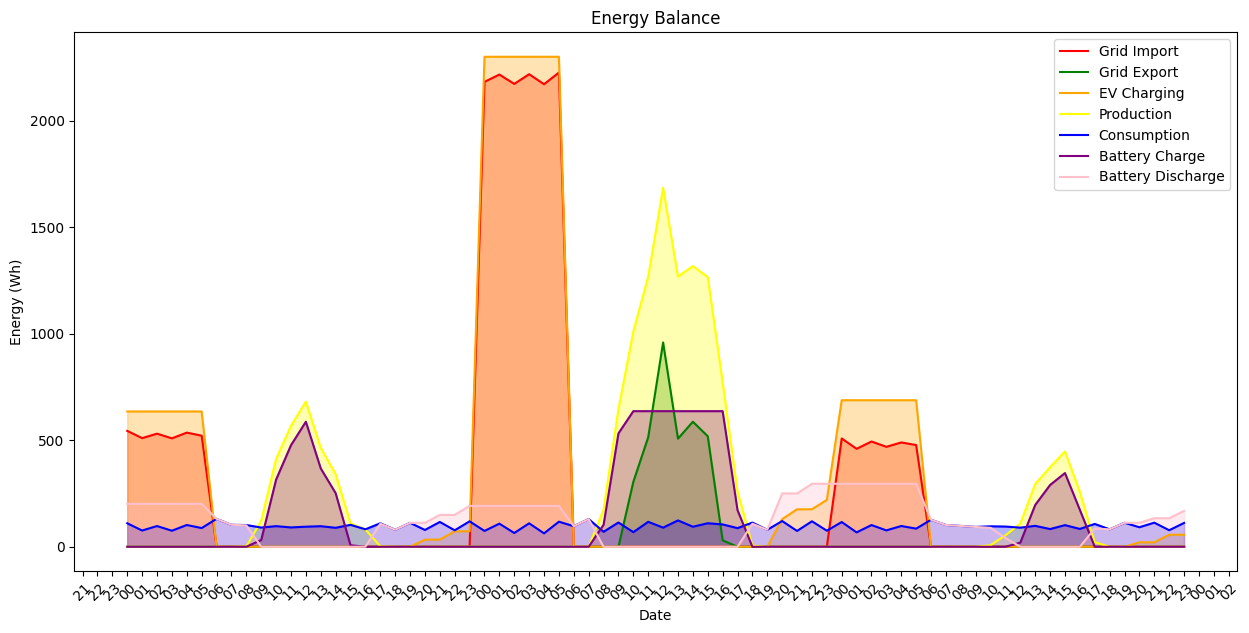

In [281]:
# same plots as before, using the results dataframe
days_between = ('2019-10-05', '2019-10-07')
df_day = df_results[(df_results['date_hour'].dt.date >= pd.to_datetime(days_between[0]).date()) &
                    (df_results['date_hour'].dt.date <= pd.to_datetime(days_between[1]).date())]

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df_day['date_hour'], df_day['grid_import'], label='Grid Import', color='red')
ax.fill_between(df_day['date_hour'], df_day['grid_import'], 0, color='red', alpha=0.3)
ax.plot(df_day['date_hour'], df_day['grid_export'], label='Grid Export', color='green')
ax.fill_between(df_day['date_hour'], df_day['grid_export'], 0, color='green', alpha=0.3)
ax.plot(df_day['date_hour'], df_day['ev_charge'], label='EV Charging', color='orange')
ax.fill_between(df_day['date_hour'], df_day['ev_charge'], 0, color='orange', alpha=0.3)
ax.plot(df_day['date_hour'], df_day['production_wh'], label='Production', color='yellow')
ax.fill_between(df_day['date_hour'], df_day['production_wh'], 0, color='yellow', alpha=0.3)
ax.plot(df_day['date_hour'], df_day['consumption_wh'], label='Consumption', color='blue')
ax.fill_between(df_day['date_hour'], df_day['consumption_wh'], 0, color='blue', alpha=0.3)
ax.plot(df_day['date_hour'], df_day['battery_charge'], label='Battery Charge', color='purple')
ax.fill_between(df_day['date_hour'], df_day['battery_charge'], 0, color='purple', alpha=0.3)
ax.plot(df_day['date_hour'], df_day['battery_discharge'], label='Battery Discharge', color='pink')
ax.fill_between(df_day['date_hour'], df_day['battery_discharge'], 0, color='pink', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Energy (Wh)')
ax.set_title('Energy Balance')
ax.legend()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xticks(rotation=45)
plt.show()

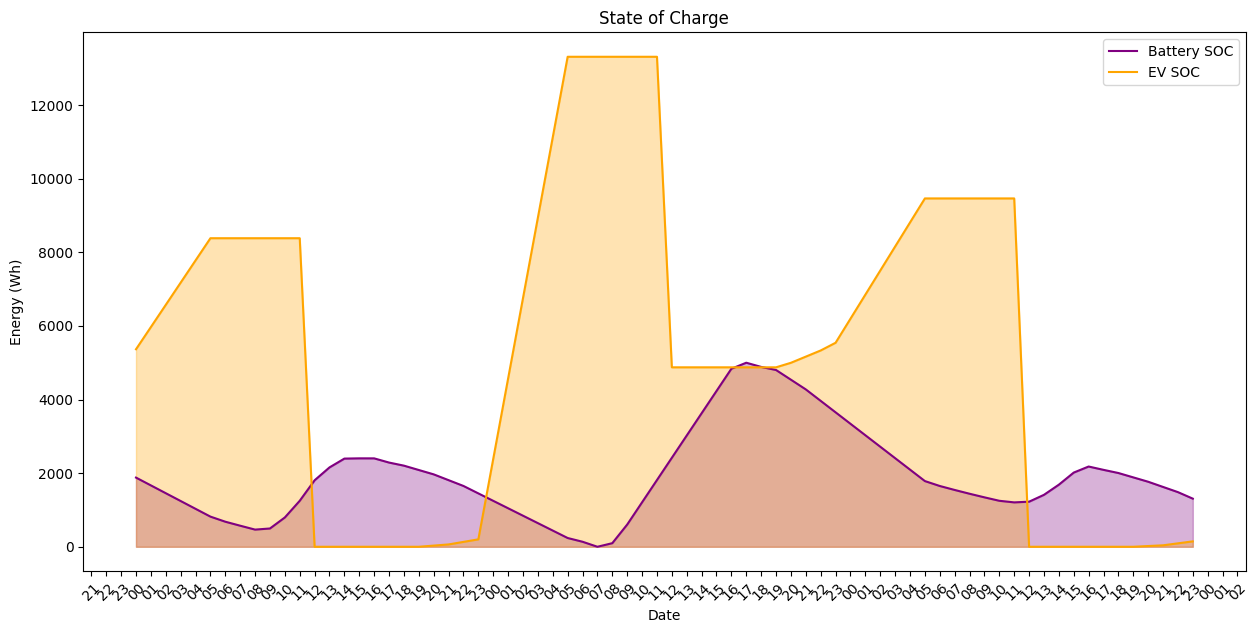

In [282]:
#plot the state of charge of the battery:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df_day['date_hour'], df_day['battery_soc'], label='Battery SOC', color='purple')
ax.fill_between(df_day['date_hour'], df_day['battery_soc'], 0, color='purple', alpha=0.3)
ax.plot(df_day['date_hour'], df_day['ev_soc'], label='EV SOC', color='orange')
ax.fill_between(df_day['date_hour'], df_day['ev_soc'], 0, color='orange', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Energy (Wh)')
ax.set_title('State of Charge')
ax.legend()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xticks(rotation=45)
plt.show()

In [283]:
df_results = df_results.round(1)
df_results.to_csv('test.csv', index=False)